In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tiffile as tiff
import glob
import re
import random
from skimage.feature import SIFT as sift
import itertools
import anndata as ad
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime

random.seed(0)


def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


def entropy(binary_image):
    cancer_cells = np.sum(binary_image * 1)
    col_divided = blockshaped(binary_image,100,100)
    
    list_of_entropies = []
    
    for instance in col_divided:
        number_of_cells = np.sum(instance * 1)
        #print(number_of_cells)
        if number_of_cells != 0:
            small_n = np.sum(number_of_cells * 1)
            ent_time = small_n / cancer_cells
            frame = ent_time * np.log(ent_time)
            list_of_entropies.append(-frame)
        else:
            list_of_entropies.append(0)
    return(list_of_entropies)


def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)



pixel_thresh = 3.5
lop_off_inteval = 116

In [2]:
# create list of integer donor IDs that we wish to use
donor_ids = [1,2,3,4]


well_ids = []

high_et = ['B','D','F','H','J']
for i in range(2,12,1):
    rasas = [str(i)]
    combos = list(itertools.product(high_et, rasas))
    newlist = ["".join(item) for item in combos ]
    well_ids.extend(newlist)

print(well_ids)

# # use very small subset of the overall dataset for prototyping
# well_ids = ['B4', 'D4', 'B10', 'D10']
# donor_ids = [1]


['B2', 'D2', 'F2', 'H2', 'J2', 'B3', 'D3', 'F3', 'H3', 'J3', 'B4', 'D4', 'F4', 'H4', 'J4', 'B5', 'D5', 'F5', 'H5', 'J5', 'B6', 'D6', 'F6', 'H6', 'J6', 'B7', 'D7', 'F7', 'H7', 'J7', 'B8', 'D8', 'F8', 'H8', 'J8', 'B9', 'D9', 'F9', 'H9', 'J9', 'B10', 'D10', 'F10', 'H10', 'J10', 'B11', 'D11', 'F11', 'H11', 'J11']


In [3]:
# load the csv files that contain the RASA2KO titrations and ET ratios for each well
rasa2ko_df = pd.read_csv('/gladstone/engelhardt/lab/adamw/saft_figuren/data/4DonorAssay_RASA2KO_titrations.csv', index_col=0)
et_ratio_df = pd.read_csv('/gladstone/engelhardt/lab/adamw/saft_figuren/data/4DonorAssay_ET_ratios.csv', index_col=0)

# convert rasa2ko_df entries of 'No TCR' and 'No T Cell' to NaN
rasa2ko_df = rasa2ko_df.replace('No TCR ', np.nan)
rasa2ko_df = rasa2ko_df.replace('No T Cell', np.nan)

# change all columns of rasa2ko_df and et_ratio_df to float64
rasa2ko_df = rasa2ko_df.astype('float64')
et_ratio_df = et_ratio_df.astype('float64')

rasa2ko_df.tail()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
L,NaN,100.0,100.0,50.0,50.0,25.0,25.0,12.5,12.5,6.3,...,15.0,7.5,7.5,3.8,3.8,1.9,1.9,0.9,0.9,NaN
M,NaN,100.0,100.0,50.0,50.0,25.0,25.0,12.5,12.5,6.3,...,15.0,7.5,7.5,3.8,3.8,1.9,1.9,0.9,0.9,NaN
N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def map_well_to_experiment(well_id, rasa2ko_df=rasa2ko_df, et_ratio_df=et_ratio_df):
    '''
    Given a well id, return the corresponding RASA2KO titration and E:T ratio.

    The first character of the well_id corresponds to the row of each dataframe.
    The second (and third) character(s) of the well_id corresponds to the column of each dataframe.
    '''
    row = well_id[0]
    col = well_id[1:]
    try:
        rasa2ko = rasa2ko_df.loc[row,col]
    except:
        print("No RASA2KO titration for well {}".format(well_id))
        rasa2ko = np.nan
    try:
        et_ratio = et_ratio_df.loc[row,col]
    except:
        print("No E:T ratio for well {}".format(well_id))
        et_ratio = np.nan
    return rasa2ko, et_ratio
    

In [5]:
def plot_representative_fn(well_id, donor_id, time_point, trim=100, lab_folder_path='/gladstone/engelhardt/lab/', save_path=None):
    '''
    Given a well id, donor id, and time point, plot the representative bright field + RFP image
    '''
    # create a list of all the image file paths that correspond to this donor_id
    donor_location_phase = lab_folder_path + "MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor{}/phase_registered/*tif".format(donor_id)
    donor_location_red = lab_folder_path + "MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor{}/red_registered/*tif".format(donor_id)
    files_phase = glob.glob(donor_location_phase)
    files_red = glob.glob(donor_location_red)

    # find the list of file paths that correspond to the specified well_id
    # store all image paths from this well in a list, sorted by timepoint
    #phase
    matching = [s for s in files_phase if (well_id + "_") in s]
    sorted_file_list_phase = (sorted_nicely(matching))
    # #red
    matching = [s for s in files_red if (well_id + "_") in s]
    sorted_file_list_red = (sorted_nicely(matching))

    # subset the list to the specified time point and load the images
    resized_latish_phase = tiff.imread(sorted_file_list_phase[time_point])
    resized_latish_red = tiff.imread(sorted_file_list_red[time_point])
    # threshold the red channel into a binary mask
    red_frame = resized_latish_red > 3.5

    # normalize intensity of the phase image
    phase_frame = cv.normalize(resized_latish_phase, None, 0, 255, cv.NORM_MINMAX).astype('uint8') 

    # plot the phase image with the red mask superimposed
    plt.figure(figsize=(6,6))
    trim=100
    plt.imshow(red_frame[trim:-trim,trim:-trim], cmap='Reds', alpha = 1.0)
    plt.imshow(phase_frame[trim:-trim,trim:-trim], cmap='gray', alpha = .75)
    plt.title('Well: {}, Donor: {}, Time: {}'.format(well_id,donor_id,time_point), size = 12)
    # remove the axes ticks and labels
    plt.axis('off')

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return


# plot_representative_fn(well_id='B4', donor_id=1, time_point=25, save_path=None)

In [6]:


# store a list of all the adata objects from each image
adata_list = []

# set the appropriate lab folder path based on the location of the data
# lab_folder_path = '/Volumes/Engelhardt-Lab/'
lab_folder_path = '/gladstone/engelhardt/lab/'

# only save 10% of the SIFT descriptors from each image to reduce the size of the adata object
downsample_pct = 0.1

for d in donor_ids:
    # get directories for phase and red images from this donor
    donor_location_phase = lab_folder_path + "MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor{}/phase_registered/*tif".format(d)
    donor_location_red = lab_folder_path + "MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor{}/red_registered/*tif".format(d)
    files_phase = glob.glob(donor_location_phase)
    files_red = glob.glob(donor_location_red)

    for w in well_ids:

        # find all the file names for the red and phase channels of this donor and well
        # phase
        matching = [s for s in files_phase if (w + "_") in s]
        sorted_file_list_phase = (sorted_nicely(matching))
        # red
        matching = [s for s in files_red if (w + "_") in s]
        sorted_file_list_red = (sorted_nicely(matching))

        # get the RASA2KO and E:T ratio for this well
        rasa2ko, et_ratio = map_well_to_experiment(w)

        max_times = len(sorted_file_list_phase)
        # # arbitrarily set max_times to 2 for now
        # max_times = 2

        # print(w,d,max_times)

        # loop through all the time points
        for t in range(max_times):

            # load the images
            resized_latish_phase = tiff.imread(sorted_file_list_phase[t])
            resized_latish_red = tiff.imread(sorted_file_list_red[t])
            # threshold the red channel into a binary mask
            aggregate_threshed = resized_latish_red > 3.5    
            
            # normalize intensity of the phase image
            phase_frame = cv.normalize(resized_latish_phase, None, 0, 255, cv.NORM_MINMAX).astype('uint8') 

            # compute the entropy and area of the red mask
            red_frame = aggregate_threshed
            red_resized = red_frame[16:-16,16:-16]
            red_entropy = np.sum(entropy(red_resized))
            p_areas = np.sum((red_frame * 1).ravel())

            # detect SIFT keypoints and extract descriptors from the phase image
            descriptor_extractor = sift()
            descriptor_extractor.detect_and_extract(phase_frame)
            keypoints1 = descriptor_extractor.keypoints
            descriptors1 = descriptor_extractor.descriptors
            scales1 = descriptor_extractor.scales
            octaves1 = descriptor_extractor.octaves
            sigmas1 = descriptor_extractor.sigmas
            orientations1 = descriptor_extractor.orientations

            # create AnnData object from the SIFT descriptors
            temp_adata = ad.AnnData(X=descriptors1)

            # add metadata to the AnnData object
            temp_adata.obs['donor_id'] = d
            temp_adata.obs['time'] = t
            temp_adata.obs['well_id'] = w
            temp_adata.obs['rasa2ko_titration'] = rasa2ko
            temp_adata.obs['et_ratio'] = et_ratio
            temp_adata.obs['entropy'] = red_entropy
            temp_adata.obs['p_areas'] = p_areas
            temp_adata.obs['filename'] = sorted_file_list_phase[t]
            temp_adata.obs['scales'] = scales1
            temp_adata.obs['octaves'] = octaves1
            temp_adata.obs['sigmas'] = sigmas1
            temp_adata.obs['orientations'] = orientations1
            temp_adata.obs['x'] = keypoints1[:,0]
            temp_adata.obs['y'] = keypoints1[:,1]

            # add a sift_ prefix to the variable names
            temp_adata.var_names = ['sift_{}'.format(i) for i in range(128)]

            # compute the original number of SIFT keypoints
            n_og_keypoints = len(keypoints1)
            temp_adata.obs['n_og_keypoints'] = n_og_keypoints

            # subset the adata object to only include 10% of the keypoints
            temp_adata = temp_adata[np.random.choice(n_og_keypoints, int(downsample_pct*n_og_keypoints), replace=False)]

            # store the adata object for this image
            adata_list.append(temp_adata)

            # raise ValueError("stop here")

# concanenate all the adata objects by row
adata = ad.concat(adata_list, join='outer')

adata

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 3389740 × 128
    obs: 'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio', 'entropy', 'p_areas', 'filename', 'scales', 'octaves', 'sigmas', 'orientations', 'x', 'y', 'n_og_keypoints'

In [7]:
# normalize the SIFT detectors
scaler = StandardScaler()
X=adata.X
scaler.fit(X)
X=scaler.transform(X)    

# run pca using 30 components
pca = PCA(n_components=30)
x_new = pca.fit_transform(X)

# add the pca coordinates to the adata object
adata.obsm['X_pca'] = x_new



In [8]:
# adata = ad.read('/gladstone/engelhardt/lab/adamw/saft_figuren/analysis/adata_20250223.h5ad')
# adata

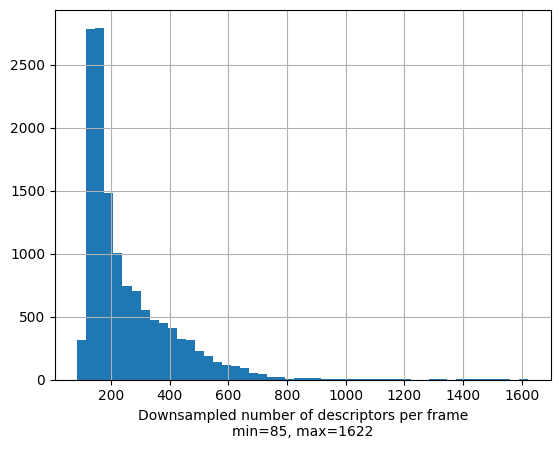

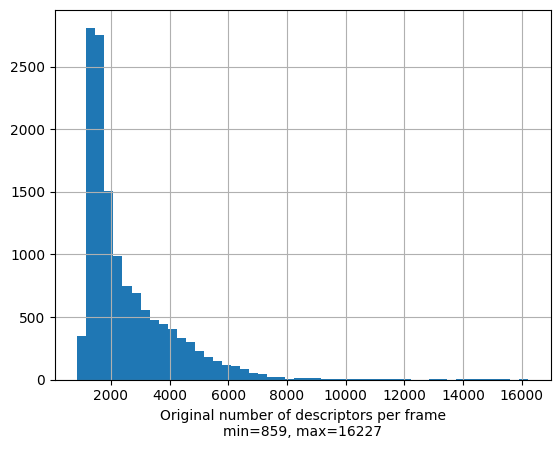

In [9]:
df = pd.DataFrame(adata.obs[['well_id', 'donor_id', 'time', 'n_og_keypoints']].value_counts())
df.columns = ['num_descriptors']

# plot a histogram of the downsampled number of descriptors per image
df['num_descriptors'].hist(bins=50)
plt.xlabel('Downsampled number of descriptors per frame\nmin={}, max={}'.format(df['num_descriptors'].min(), df['num_descriptors'].max()))
plt.show()

# plot a histogram of the original number of descriptors per image
df.reset_index(inplace=True)
df['n_og_keypoints'].hist(bins=50)
plt.xlabel('Original number of descriptors per frame\nmin={}, max={}'.format(df['n_og_keypoints'].min(), df['n_og_keypoints'].max()))
plt.show()


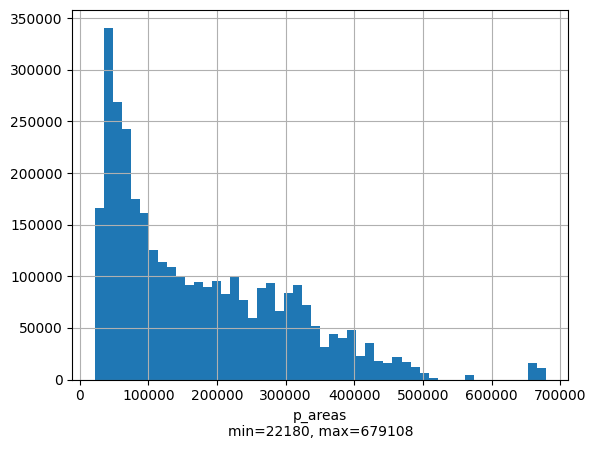

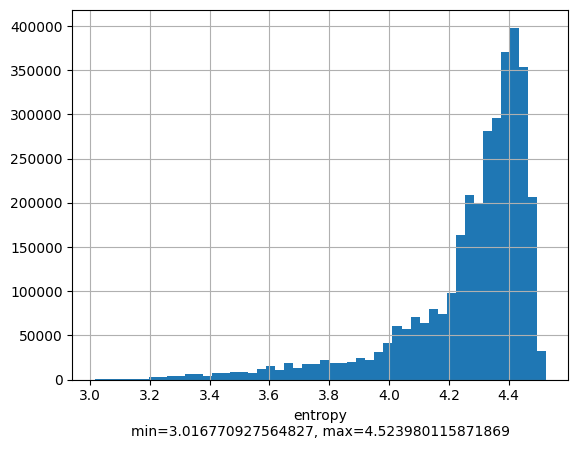

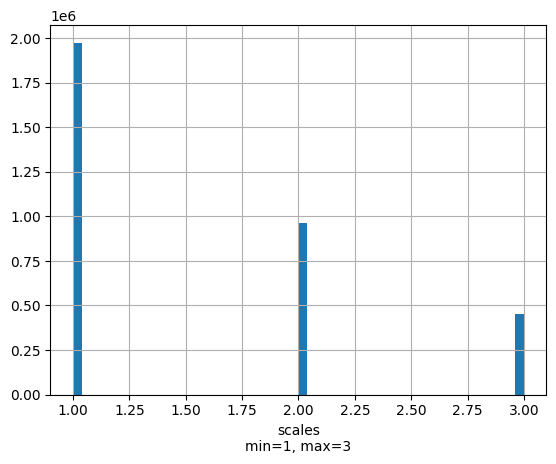

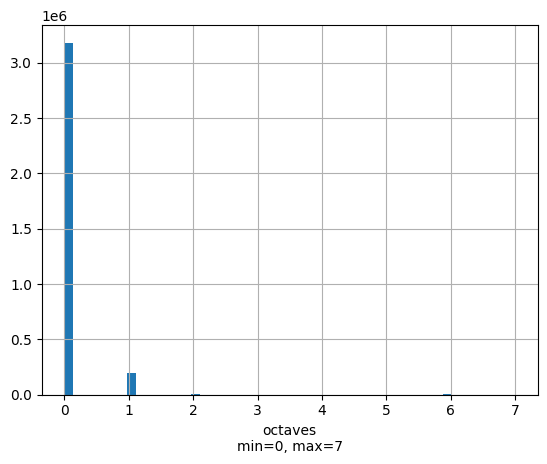

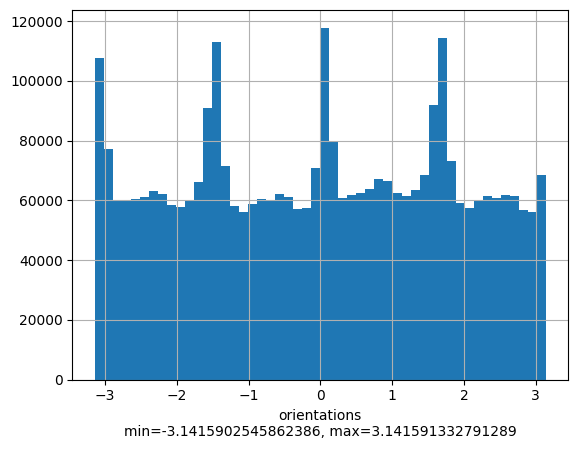

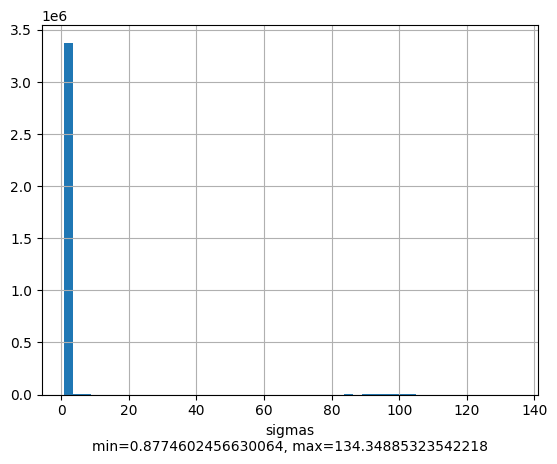

In [10]:
for col in ['p_areas', 'entropy', 'scales', 'octaves', 'orientations', 'sigmas']:
    adata.obs[col].hist(bins=50)
    plt.xlabel('{}\nmin={}, max={}'.format(col, adata.obs[col].min(), adata.obs[col].max()))
    plt.show()

In [11]:
# extract the current date in the format YYYYMMDD
current_date = datetime.datetime.now().strftime("%Y%m%d")
current_date

# save the adata object
adata.write('/gladstone/engelhardt/lab/adamw/saft_figuren/analysis/adata_{}.h5ad'.format(current_date))